In this notebook we model the data at the level of overlapping frames. E.g.
 * frame_length: 25ms
 * hop_length: 10ms

 In this way, we have 15ms overlap so retain contextual information inbetween frames. Note that `sr = 44100` and `len(audio) = 220500` for our dataset.<br>
 ##### Broad idea for getting samples out of data
 With a frame length of 25ms, each sample contains 0.025 * 44100 = 1102.5 ~ 1102 samples per frame. <br>
 Each hop shifts by 0.01 * 44100 = 441 samples. <br>

So our window size is 1102 and our "jump" is 441. Using $N_{\text{frames}} = 1 + \left\lfloor \frac{N_{\text{samples}} - N_{\text{frame}}}{\text{hop}} \right\rfloor$, we have $N_{\text{frames}}= 1 + \left\lfloor 497.5 \right\rfloor = 1 + 497 = 498$. This massively increases the potential feature space from our baseline model working with simple aggregated features.

In [ ]:
import soundata
from torch.utils.data import Dataset
import torch
import sys
from pathlib import Path
# from IPython.display import Audio breaks the notebook
import torch
import numpy as np
import pandas as pd
import librosa.feature
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


project_root = Path("/Users/daniellevy/bioacoustic-classifier")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from src.data_utils import UrbanSoundTorchDataset
from src.frame_level_model import extract_frame_level_features
from src.eda import plot_grouped_histograms, plot_feature_correlation_heatmap
from src.baseline_model import train_baseline_model, gridsearch_model
from src.model_performance import compute_accuracy_measures, plot_confusion_matrix

In [2]:
# create an instance of "soundata.datasets.urbansound8k.Dataset" - class which wraps the entire UrbanSound8K dataset
dataset = soundata.initialize("esc50", data_home="/Users/daniellevy/bioacoustic-classifier/data/ESC-50-master")
dataset.validate()

meta = pd.read_csv(str(Path(project_root / "data" / "ESC-50-master" / "meta" / "esc50.csv")))
meta['filename'] = meta['filename'].str.removesuffix('.wav')
meta = meta.rename(columns ={'filename':'cid'})

esc_50 = UrbanSoundTorchDataset(dataset, fold=[1, 2, 3, 4, 5])

100%|██████████| 2000/2000 [00:01<00:00, 1027.09it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


In [ ]:
# no need to run if csv already exists
all_frames = extract_frame_level_features(dataset, 1102, 441, n_jobs=-1)
all_frames_df = pd.DataFrame(all_frames)
all_frames_df.to_csv(str(Path(project_root / "data" / "processed_data" / "frame_level_model.csv")))

In [3]:
# load in csv at frame level and add in category
all_frames_df = pd.read_csv(str(Path(project_root / "data" / "processed_data" / "frame_level_model.csv")))
all_frames_df = all_frames_df.drop(columns =['Unnamed: 0'])
all_frames_df = pd.merge(all_frames_df, meta[['cid','category']], on = 'cid')

In [4]:
animal_noises = ['crow', 'cow','cat', 'chirping_birds', 'pig', 'crickets','frog','insects', 'rooster', 'hen', 'crying_baby', 'dog', 'sheep']
quantitative = ['rms', 'zcr', 'spec_cent', 'spec_bw']

In [ ]:
# check the histograms at the level of categories
plot_grouped_histograms(df=all_frames_df[all_frames_df['category'].isin(animal_noises)], group_col = 'category', value_col = 'spec_cent', figsize = (30,30))

In [ ]:
# plot the distribution of a given quantitative column for a single sample of a given category
def plot_histogram_sample_category(category, quantitative_col, figsize):
    cid_ex = all_frames_df[all_frames_df['category'] == category].sample(1)['cid'].values[0]
    plot_grouped_histograms(
            df=all_frames_df[all_frames_df['cid'] == cid_ex],
            group_col = 'cid',
            value_col = quantitative_col,
            figsize = figsize)
    return cid_ex

plot_histogram_sample_category('clapping', 'spec_cent', (18,12))

In [5]:
# we cannot just use all these observations as they are extremely non-i.i.d, indeed they overlap and these 996000 data points come from 2000 sound samples, so we have a lot of within sample correlation.
# we therefore aggregate at the level of cid. By obtaining std we have an idea how varied some of the signals are across these metrics

feature_cols = [
    'rms', 'zcr', 'spec_cent', 'spec_bw',
    'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6',
    'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13'
]

aggregations = ['mean', 'std', 'median']

agg_df = (
    all_frames_df
    .groupby(['cid', 'category','fold'])[feature_cols]
    .agg(aggregations)
    .reset_index()
)

agg_df.columns = [
    "_".join(col).strip("_") if isinstance(col, tuple) else col
    for col in agg_df.columns
]

In [ ]:
# again build up test/train
non_feature_cols = ['cid', 'category', 'fold']
folds = [1, 2, 3, 4, 5]
test_fold = 4 # choose
train_folds = [f for f in folds if f != test_fold]

test = agg_df[agg_df['fold'] == test_fold]
train = agg_df[agg_df['fold'].isin(train_folds)]

# Select features (all columns except metadata)
feature_cols = [c for c in agg_df.columns if c not in non_feature_cols]

X_train = train[feature_cols].values
X_test = test[feature_cols].values

y_train = train['category']
y_test = test['category']

# for CV later in grid-search we need to keep track of fold indices
fold_indices = train["fold"].values
fold_indices = fold_indices - 1
ps = PredefinedSplit(test_fold=fold_indices)

del test
del train

In [20]:
model_lr, scaler_lr = train_baseline_model(
    X_train, y_train, 
    model_type='lr',
    C=0.5,
    penalty='l2',
    solver='lbfgs'
)

In [21]:
model_rf, scaler_rf = train_baseline_model(
    X_train, y_train, 
    model_type='rf',
    n_estimators=300,
    max_depth=10,
    min_samples_split=4
)

In [22]:
X_test_scaled_lr = scaler_lr.transform(X_test)
X_test_scaled_rf = scaler_rf.transform(X_test)

y_pred_lr = model_lr.predict(X_test_scaled_lr)
y_pred_rf = model_rf.predict(X_test_scaled_rf)

In [23]:
# lr stats - significant improvement with using the features derived from samples opposed to global aggregations
compute_accuracy_measures(y_test, y_pred_lr)

Accuracy: 0.4775
Precision (macro): 0.5072961972667855
Recall (macro): 0.4775
F1 (macro): 0.4637534334482914

Detailed classification report:
                  precision    recall  f1-score   support

        airplane       0.25      0.25      0.25         8
       breathing       0.38      0.38      0.38         8
  brushing_teeth       0.57      0.50      0.53         8
     can_opening       0.50      0.75      0.60         8
        car_horn       0.43      0.38      0.40         8
             cat       0.50      0.25      0.33         8
        chainsaw       0.00      0.00      0.00         8
  chirping_birds       0.33      0.25      0.29         8
    church_bells       0.39      0.88      0.54         8
        clapping       0.50      0.88      0.64         8
     clock_alarm       0.50      0.62      0.56         8
      clock_tick       0.33      0.38      0.35         8
        coughing       0.67      0.50      0.57         8
             cow       0.67      0.50      0.

In [24]:
# rf stats, slightly less than lr but still a significant improvement
compute_accuracy_measures(y_test, y_pred_rf)

Accuracy: 0.4525
Precision (macro): 0.45517147884794945
Recall (macro): 0.4525
F1 (macro): 0.4202993541769008

Detailed classification report:
                  precision    recall  f1-score   support

        airplane       0.50      0.38      0.43         8
       breathing       0.25      0.12      0.17         8
  brushing_teeth       0.56      0.62      0.59         8
     can_opening       0.67      0.75      0.71         8
        car_horn       1.00      0.12      0.22         8
             cat       0.00      0.00      0.00         8
        chainsaw       0.33      0.38      0.35         8
  chirping_birds       0.67      0.50      0.57         8
    church_bells       0.40      0.75      0.52         8
        clapping       0.56      0.62      0.59         8
     clock_alarm       1.00      0.50      0.67         8
      clock_tick       0.33      0.25      0.29         8
        coughing       0.38      0.38      0.38         8
             cow       0.50      0.25      0

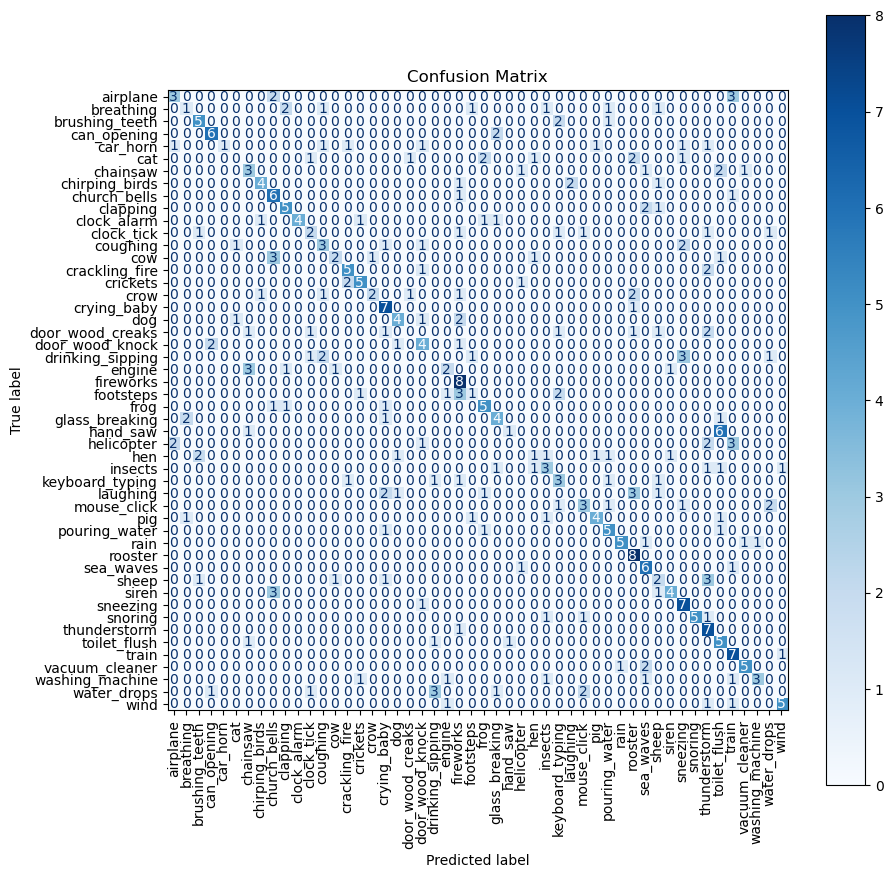

In [25]:
plot_confusion_matrix(y_pred_rf, y_test, model_rf)

We have a significant improvement across all metrics by computing statistics over frames rather than using global (clip) level aggregated statistics. Let's dive into the rf model a bit more and see if we can extract some more performance.

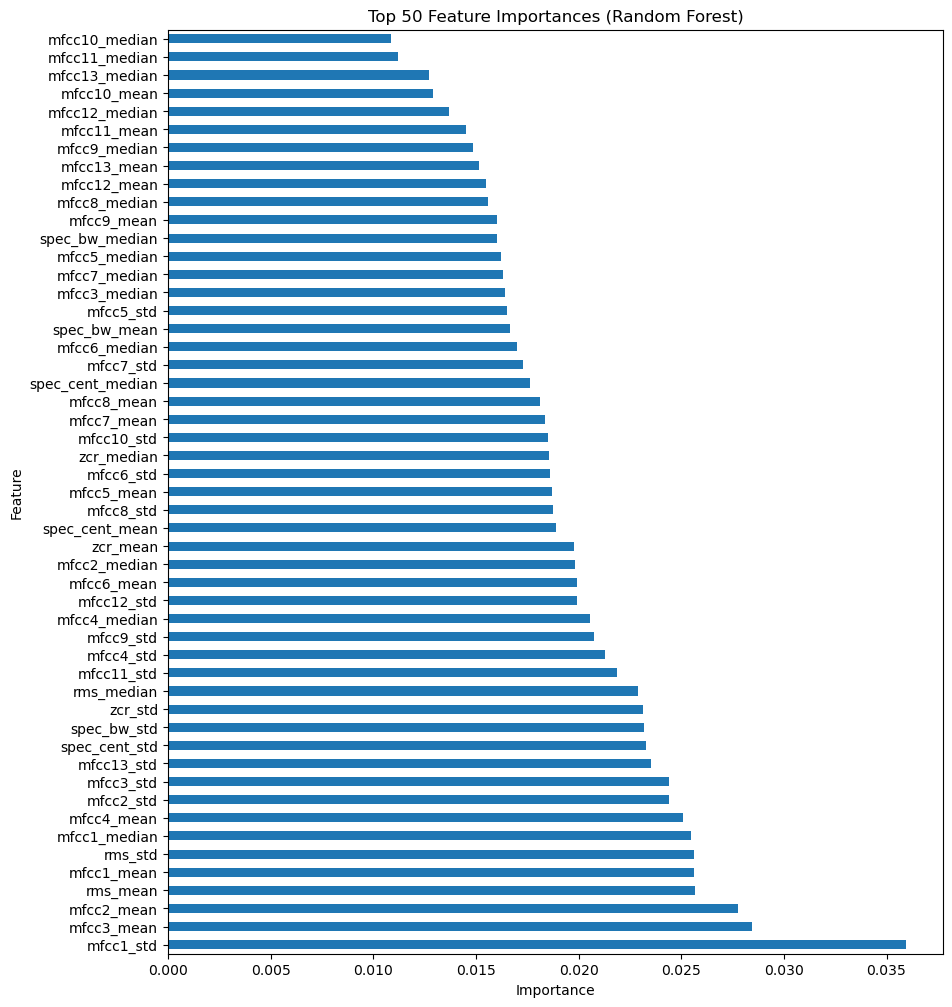

In [26]:
# check importance of RF features. We see that feature importance is reasonably well distributed

importances = pd.Series(model_rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(10, 12))  # width, height in inches
importances.head(51).plot(kind='barh')
plt.title("Top 50 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

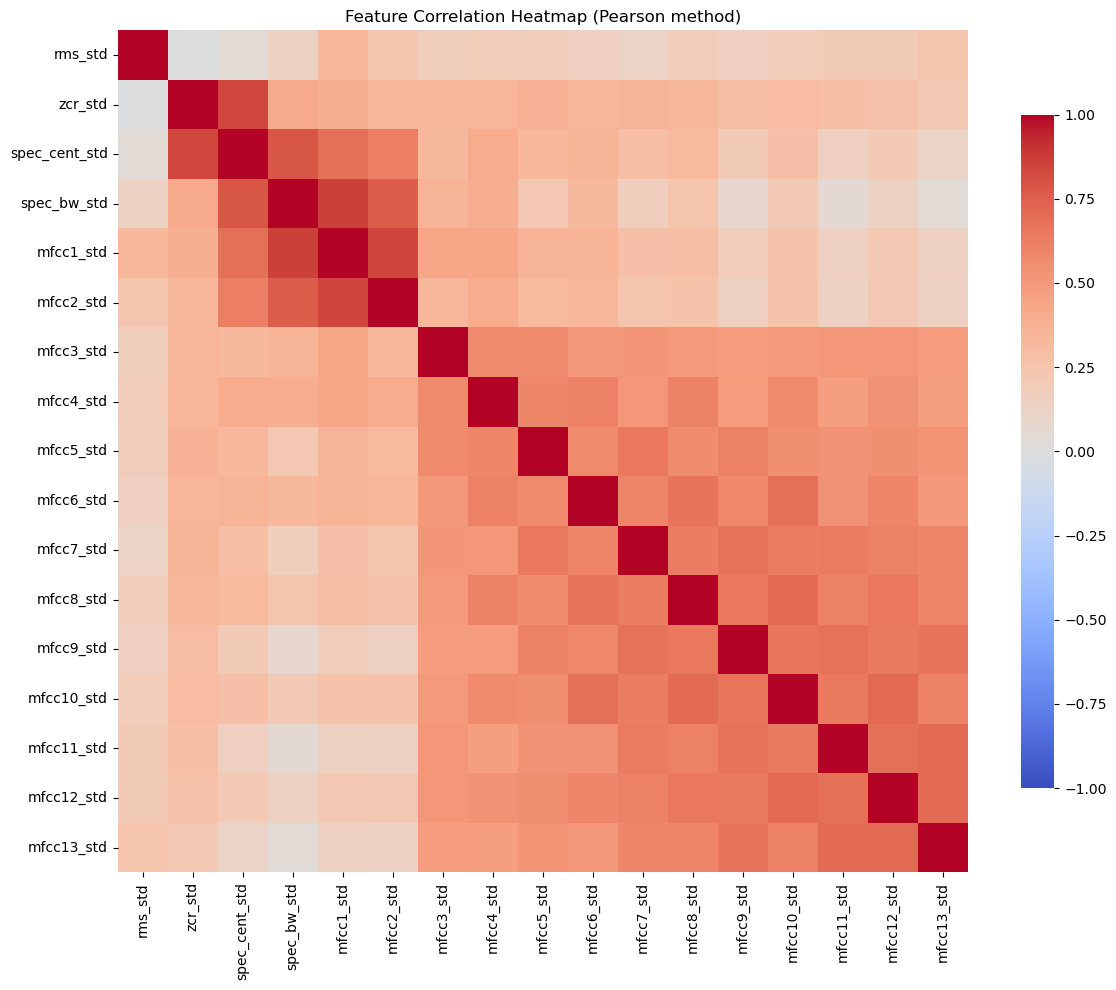

In [17]:
# check correlations - we have correlations between different statistics for the same metric (e.g. rms) so option to select one aggregation
suffix = 'std'
feature_cols_type = [c for c in feature_cols if c.endswith(suffix)]
plot_feature_correlation_heatmap(agg_df, feature_cols_type, figsize=(12, 10), corr_method='pearson', vmin=-1, vmax=1)

In [35]:
# Define parameter grid for Logistic Regression
param_grid_lr = {
    # Regularization strength
    'C': [0.001, 0.01, 0.1, 1, 10],

    # Type of regularization
    'penalty': ['l2'],

    # Solver
    'solver': ['lbfgs'],
}

# Run grid search with predefined folds
best_lr_model, best_lr_params = gridsearch_model(
    X_train,
    y_train,
    model_type='lr',
    param_grid=param_grid_lr,
    cv=ps  # PredefinedSplit created from fold column
)

# Best params for lr: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
# Best CV score: 0.3962

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END model__C=0.001, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.001, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.001, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.001, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs; total time=   0.0s
[CV] END model__C=0.1, mod

In [ ]:
# Define parameter grid for Random Forest
param_grid_rf = {
    # Number of trees 
    'n_estimators': [100, 300, 500],

    # Maximum depth of tree
    'max_depth': [None, 10, 20],

    # Minimum samples to split a node
    'min_samples_split': [2, 5, 10],

    # Minimum samples per leaf node
    'min_samples_leaf': [1, 2, 4],

    # Number of features to consider at each split
    'max_features': ['sqrt', 'log2']
}

best_rf_model, best_rf_params = gridsearch_model(
    X_train,
    y_train,
    model_type='rf',
    param_grid=param_grid_rf,
    cv=ps
)

# Best params for rf: {'model__max_depth': 20, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
# Best CV score: 0.3994

Fitting 4 folds for each of 162 candidates, totalling 648 fits
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.6s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   0.6s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   

/opt/anaconda3/envs/bioaudio/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=300; total time=   1.6s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100; total time=   0.4s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100; total time=   0.4s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100; total time=   0.4s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100; total time=   0.5s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500; total time=   2.4s
[CV] END model__max_depth=None, model__max_features=lo

In [ ]:
# given grid search, best params:
best_params = {
    'max_depth': 20,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 300
}

final_model = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # optional for RF
    ('model', RandomForestClassifier(random_state=42, **best_params))
])

final_model.fit(X_train, y_train)
y_pred_rf_final = final_model.predict(X_test)

compute_accuracy_measures(y_test, y_pred_rf_final) # a little more performance with hyper-parameter tuning

Accuracy: 0.4725
Precision (macro): 0.5017308947502447
Recall (macro): 0.4725
F1 (macro): 0.4505871565136877

Detailed classification report:
                  precision    recall  f1-score   support

        airplane       0.60      0.38      0.46         8
       breathing       0.25      0.12      0.17         8
  brushing_teeth       0.62      0.62      0.62         8
     can_opening       0.83      0.62      0.71         8
        car_horn       1.00      0.25      0.40         8
             cat       0.00      0.00      0.00         8
        chainsaw       0.50      0.50      0.50         8
  chirping_birds       0.57      0.50      0.53         8
    church_bells       0.38      0.75      0.50         8
        clapping       0.44      0.50      0.47         8
     clock_alarm       1.00      0.62      0.77         8
      clock_tick       0.38      0.38      0.38         8
        coughing       0.29      0.25      0.27         8
             cow       0.50      0.25      0.

In [ ]:
# do CV using the given folds in the dataset

cv_results = []
for test_fold_cv in folds:
    train_folds_cv = [f for f in folds if f != test_fold_cv]

    # Split data
    train_cv = agg_df[agg_df['fold'].isin(train_folds_cv)]
    test_cv  = agg_df[agg_df['fold'] == test_fold_cv]

    X_train_cv = train_cv[feature_cols].values
    y_train_cv = train_cv['category']
    X_test_cv  = test_cv[feature_cols].values
    y_test_cv  = test_cv['category']

    # Re-instantiate model each time to reset state 
    model_cv = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('model', RandomForestClassifier(
            random_state=42,
            max_depth=20,
            max_features='log2',
            min_samples_leaf=1,
            min_samples_split=2,
            n_estimators=300
        ))
    ])

    # Train and evaluate
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_test_cv)

    cv_results.append({
        "fold": test_fold_cv,
        "accuracy": accuracy_score(y_test_cv, y_pred_cv),
        "precision_macro": precision_score(y_test_cv, y_pred_cv, average='macro', zero_division=0),
        "recall_macro": recall_score(y_test_cv, y_pred_cv, average='macro', zero_division=0),
        "f1_macro": f1_score(y_test_cv, y_pred_cv, average='macro', zero_division=0)
    })

# Convert to DataFrame for summary
cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)
print("\nMean CV Results:")
print(cv_results_df.mean(numeric_only=True))

   fold  accuracy  precision_macro  recall_macro  f1_macro
0     1    0.3900         0.369426        0.3900  0.366216
1     2    0.4150         0.435037        0.4150  0.395478
2     3    0.4475         0.438310        0.4475  0.414748
3     4    0.4725         0.501731        0.4725  0.450587
4     5    0.4000         0.393811        0.4000  0.377537

Mean CV Results:
fold               3.000000
accuracy           0.425000
precision_macro    0.427663
recall_macro       0.425000
f1_macro           0.400913
dtype: float64
